In [2]:
import uproot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import awkward as ak
import numpy as np
import math
import ROOT as root

Welcome to JupyROOT 6.26/16


Returning to the edep-sim files. Let's check if the ones in the home directory match the reco files. Back into the world of JupyRoot

In [3]:
reco_file = root.TFile("/sdf/home/t/tanaka/tms/MicroProdN4p1/run-tms-reco/MicroProdN4p1_NDComplex_FHC.tmsreco.full/TMSRECO/0002000/0002400/MicroProdN4p1_NDComplex_FHC.tmsreco.full.0002459.TMSRECO.root")
edep_file_rocketc = root.TFile("/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.edep.rockantindlarfid.0024577.EDEPSIM.root")
edep_file_ndlar = root.TFile("/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.edep.ndlarfid.0023670.EDEPSIM.root")
events_rocketc = edep_file_rocketc.Get("EDepSimEvents")
events_ndlar = edep_file_ndlar.Get("EDepSimEvents")
event_rocketc = root.TG4Event()
event_ndlar = root.TG4Event()
events_rocketc.SetBranchAddress("Event",root.AddressOf(event_rocketc))
events_ndlar.SetBranchAddress("Event",root.AddressOf(event_ndlar))
#This tells us the total events in each:
print(events_rocketc.GetEntries()) #can check entries in the trees
print(events_ndlar.GetEntries()) 

568
27


In [4]:
events_rocketc.GetEntry(3)

29459

In [5]:
#declare the hit segments 
rocketc_tms_hit_segs = event_rocketc.SegmentDetectors['volTMS']
ndlar_tms_hit_segs = event_ndlar.SegmentDetectors['volTMS']
print(f'TMS Hits {rocketc_tms_hit_segs.size()}')
print(f'NDLAr Hits {ndlar_tms_hit_segs.size()}') #for what it is worth not even sure if these are being modeled right...
for seg in rocketc_tms_hit_segs:
    print((seg.GetStart()[0] + seg.GetStop()[0])/2)

TMS Hits 14
NDLAr Hits 0
-1395.5445892539328
-1382.340316537377
-1388.5273849845034
-1394.8684912633694
-1371.4305137129268
-1371.089705464105
-1453.990185269213
-1455.460226815848
-1455.6224720676541
-1538.53974109732
-1544.961809449808
-1545.2709285756187
-1552.3535152898967
-1369.7674652451406


In [6]:
#creates a average hit from a TMS hit segment (practice doing functions!)
class avg_hit:
    def __init__(self, tms_hit_seg):
        self.tms_hit_seg = tms_hit_seg
    def GetHitX(self):
        x_pos = (self.tms_hit_seg.GetStart()[0] + self.tms_hit_seg.GetStop()[0]) / 2
        return(x_pos)
    def GetHitY(self):
        y_pos = (self.tms_hit_seg.GetStart()[1] + self.tms_hit_seg.GetStop()[1]) / 2
        return(y_pos)
    def GetHitZ(self):
        z_pos = (self.tms_hit_seg.GetStart()[2] + self.tms_hit_seg.GetStop()[2]) / 2
        return(z_pos)

hit_test = avg_hit(rocketc_tms_hit_segs[0])
hit_test.GetHitX()
hit_test.GetHitY()

#The way that the bar finding in the TMS_bar.cpp file works is by first doing this hit averaging, then inputs into a FindModule function that 
#searches the geometry for the closest bar. It then reformats hits and stuff. 

-2803.9168418827194

Lets take a look at where the true neutrino vertices live

In [7]:
#Back to uproot, want to check some stuff out about where true neutrinto vertices are stored in the edep-sim file
#I think that these are the primary vertices -> note primaries does not mean neutrinos!!. 
edep_file_rocketc_uproot = uproot.open("/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.edep.rockantindlarfid.0024577.EDEPSIM.root")
print(edep_file_rocketc_uproot['DetSimPassThru']['gRooTracker']['EvtVtx'].arrays())
edep_file_ndlarfd_uproot = uproot.open("/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.edep.ndlarfid.0023670.EDEPSIM.root")
print(edep_file_ndlarfd_uproot['DetSimPassThru']['gRooTracker']['EvtVtx'].arrays())

[{EvtVtx: [5.26, -3.73, 23.6, 1.02e-06]}, {...}, ..., {EvtVtx: [4.47, ...]}]
[{EvtVtx: [-1.99, 0.116, 7.39, 3.48e-08]}, {...}, ..., {EvtVtx: [-2.95, ...]}]


In [8]:
edep_file_rocketc_uproot['DetSimPassThru']['gRooTracker'].keys()

['EvtFlags',
 'EvtFlags/TObject',
 'EvtFlags/fNbits',
 'EvtFlags/fNbytes',
 'EvtFlags/fAllBits',
 'EvtCode',
 'EvtCode/TObject',
 'EvtCode/fString',
 'EvtNum',
 'EvtXSec',
 'EvtDXSec',
 'EvtKPS',
 'EvtWght',
 'EvtProb',
 'EvtVtx',
 'StdHepN',
 'StdHepPdg',
 'StdHepStatus',
 'StdHepRescat',
 'StdHepX4',
 'StdHepP4',
 'StdHepPolz',
 'StdHepFd',
 'StdHepLd',
 'StdHepFm',
 'StdHepLm']

In [9]:
#I think that these are actually the neutrino vertices!! 
event_vtx_lists_rocketc = edep_file_rocketc_uproot['DetSimPassThru']['gRooTracker']['StdHepX4'].arrays().StdHepX4
#edep_file_rocketc_uproot['DetSimPassThru']['gRooTracker']['StdHepX4'].arrays().StdHepX4[1][0][0]

In [10]:
#all of the gRoot pdgids, we can see that it is saving neutrino pdgids here. 
event_pdg_lists_rocketc = edep_file_rocketc_uproot['DetSimPassThru']['gRooTracker']['StdHepPdg'].arrays().StdHepPdg

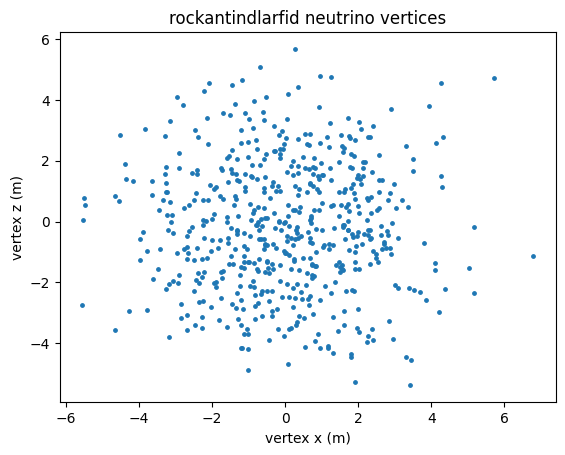

<Array [1, 2, 5, 17, 18, ..., 3865, 3877, 3882, 3883, 3890] type='568 * int32'>

In [13]:
#Ok lets actually properly plot the neutrino vertices from the rockantindlarfid and ndlarfid files, starting from top
#Fetching the array
edep_file_rockantindlarfid_uproot = uproot.open("/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.edep.rockantindlarfid.0024577.EDEPSIM.root")
edep_file_ndlarfd_uproot = uproot.open("/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.edep.ndlarfid.0023670.EDEPSIM.root")
gRooTracker_tree_rockantindlarfid = edep_file_rockantindlarfid_uproot['DetSimPassThru']['gRooTracker'] #grabbing tracker tree
gRooTracker_tree_ndlarfd = edep_file_ndlarfd_uproot['DetSimPassThru']['gRooTracker'] #grabbing tracker tree
event_vtx_list_rockantindlarfid = gRooTracker_tree_rockantindlarfid['StdHepX4'].arrays().StdHepX4 #grabbing vertex list
event_vtx_list_ndlarfd = gRooTracker_tree_ndlarfd['StdHepX4'].arrays().StdHepX4  #grabbing vertex list

#Grabbing what we need from the arrays
rockantindlarfid_neutrino_x = event_vtx_list_rockantindlarfid[0:,0,0]
rockantindlarfid_neutrino_y = event_vtx_list_rockantindlarfid[0:,0,1]
rockantindlarfid_neutrino_z = event_vtx_list_rockantindlarfid[0:,0,2]


ndlarfd_neutrino_x = event_vtx_list_ndlarfd[0:,0,0]
ndlarfd_neutrino_y = event_vtx_list_ndlarfd[0:,0,1]
ndlarfd_neutrino_z = event_vtx_list_ndlarfd[0:,0,2]

#Plotting
plt.scatter(rockantindlarfid_neutrino_x, rockantindlarfid_neutrino_z, s = 6)
plt.xlabel("vertex x (m)")
plt.ylabel("vertex z (m)")
plt.title("rockantindlarfid neutrino vertices")
plt.show()
gRooTracker_tree_rockantindlarfid['EvtNum'].arrays().EvtNum

Text(0.5, 1.0, 'ndlarfd neutrino vertices')

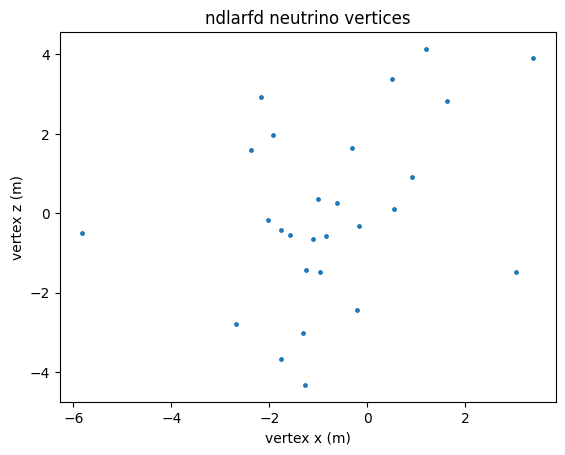

In [12]:
plt.scatter(ndlarfd_neutrino_x, ndlarfd_neutrino_z, s = 6)
plt.xlabel("vertex x (m)")
plt.ylabel("vertex z (m)")
plt.title("ndlarfd neutrino vertices")

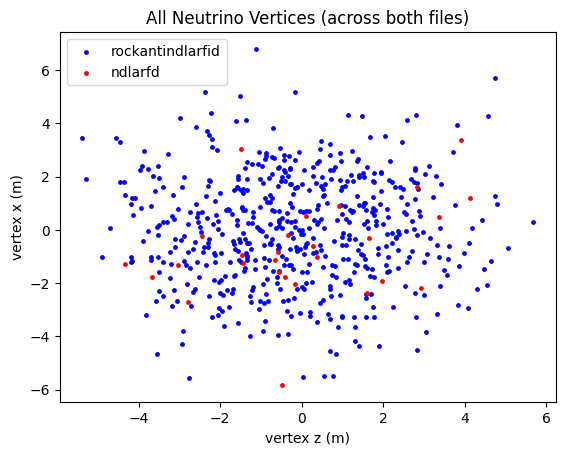

In [74]:
plt.scatter(rockantindlarfid_neutrino_z,rockantindlarfid_neutrino_x, s = 6, c = 'blue', label='rockantindlarfid')
plt.scatter(ndlarfd_neutrino_z,ndlarfd_neutrino_x, s = 6, c = 'red', label='ndlarfd')
plt.xlabel("vertex z (m)")
plt.ylabel("vertex x (m)")
plt.title("All Neutrino Vertices (across both files)")
plt.legend()

In [ ]:
#So we can definetly get neutrino vertex information... fun stuff.

In [ ]:
#lets check out geometry if provided:
